# PEP Prediction Model Training in Python

This notebook trains Gradient Boosting Machine (GBM) models for PEP (Post-ERCP Pancreatitis) prediction, converting the original R-based models to Python.

## Models trained:
1. **Main GBM model** - trained on the full dataset
2. **Therapy-specific GBM models** - trained on subsets for different treatments:
   - Aggressive hydration only
   - Indomethacin only
   - Aggressive hydration and indomethacin
   - PD stent only
   - Indomethacin and PD stent

The models use the same preprocessing and parameters as the original R implementation to ensure consistency.

In [40]:
# Import required packages for R-exact implementation
import numpy as np
import pandas as pd
from skimpy import skim
import os
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import cohen_kappa_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)

In [51]:
# Read RAW data before imputation
dt_raw = pd.read_excel("/Users/emilyguan/Downloads/EndoScribe/pep_prediction/AlbertCodeFiles/data/Combined sheet final December.xlsx")
dt_raw.columns

Index(['Study', 'Age', 'Gender ', 'BMI', 'SOD', 'Type_of_SOD',
       'History_of_PEP', 'Recurr_panc', 'Panc_Sphinc', 'Precut_Sphinc',
       'Min_pap_sphinc', 'Failed_cann', 'Diff_cann', 'Pneum_dil_woBS',
       'Panc_inj', 'Panc_inj>2', 'Acinarz', 'Panc_brush_cyto', 'Panc_div',
       'Trainee', 'Cholecy', 'PB_mal', 'GW_cann', 'GW_passPD', '>2GW_passPD',
       'Bil_sphinc', 'NSAID_use', 'intensive_hydration', 'PD_STENT', 'PEP',
       'PEP_severity'],
      dtype='object')

In [54]:


# Clean variable names
dt = dt_raw.copy()
dt.columns = dt.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
dt = dt.dropna(subset=['pep'])  # blank rows
# Convert values with "." to None
dt.replace('.', np.nan, inplace=True)

# Add patient_id (matching R: mutate(patient_id = 1:n()))
dt['patient_id'] = range(1, len(dt) + 1)

# Rename columns
dt = dt.rename(columns={
    'study': 'study_id',
    'panc_inj>2': 'pancreatic_duct_injections_2',
    'age': 'age_years',
    'gender_': 'gender_male_1',
    'recurr_panc': 'hx_of_recurrent_pancreatitis',
    'panc_sphinc': 'pancreatic_sphincterotomy',
    'precut_sphinc': 'precut_sphincterotomy',
    'min_pap_sphinc': 'minor_papilla_sphincterotomy',
    'failed_cann': 'failed_cannulation',
    'diff_cann': 'difficult_cannulation',
    'pneum_dil_wobs': 'pneumatic_dilation_of_intact_biliary_sphincter',
    'panc_inj': 'pancreatic_duct_injection',
    'acinarz': 'acinarization',
    'panc_brush_cyto': 'pancreatic_duct_brush_cytology',
    'panc_div': 'pancreas_divisum',
    'trainee': 'trainee_involvement',
    'cholecy': 'cholecystectomy',
    'pb_mal': 'pancreo_biliary_malignancy',
    'gw_cann': 'guidewire_cannulation',
    'gw_passpd': 'guidewire_passage_into_pancreatic_duct',
    '>2gw_passpd': 'guidewire_passage_into_pancreatic_duct_2',
    'bil_sphinc': 'biliary_sphincterotomy',
    'intensive_hydration': 'aggressive_hydration',
    'nsaid_use': 'indomethacin_nsaid_prophylaxis',
    'pd_stent': 'pancreatic_duct_stent_placement'
})

# Convert data types
dt['study_id'] = dt['study_id'].astype('category')
dt['pep'] = dt['pep'].astype('category')
dt['bmi'] = pd.to_numeric(dt['bmi'], errors='coerce')

# "Dummy variables" and "Near zero variance features" sections in Rmd
# early on, they remove pep_severity
# "due to high missingness and redundancy with `sod`, I will remove `type_of_sod`."
# "For now, I've chosen to remove the `pancreatic_duct_brush_cytology` and `pancreas_divisum` features

dt = dt.drop(columns=['pep_severity', 'type_of_sod', 'pancreatic_duct_brush_cytology', 'pancreas_divisum'])

print(f"Raw data loaded (dt): {dt.shape}")
print(f"{len(dt.columns.tolist())} Features: {dt.columns.tolist()}")
dt.head()

"""At this point, there are 28 features in R."""

Raw data loaded (dt): (7389, 28)
28 Features: ['study_id', 'age_years', 'gender_male_1', 'bmi', 'sod', 'history_of_pep', 'hx_of_recurrent_pancreatitis', 'pancreatic_sphincterotomy', 'precut_sphincterotomy', 'minor_papilla_sphincterotomy', 'failed_cannulation', 'difficult_cannulation', 'pneumatic_dilation_of_intact_biliary_sphincter', 'pancreatic_duct_injection', 'pancreatic_duct_injections_2', 'acinarization', 'trainee_involvement', 'cholecystectomy', 'pancreo_biliary_malignancy', 'guidewire_cannulation', 'guidewire_passage_into_pancreatic_duct', 'guidewire_passage_into_pancreatic_duct_2', 'biliary_sphincterotomy', 'indomethacin_nsaid_prophylaxis', 'aggressive_hydration', 'pancreatic_duct_stent_placement', 'pep', 'patient_id']


'At this point, there are 28 features in R.'

In [55]:
# Fix specific missing/typo logic
dt['aggressive_hydration'] = dt['aggressive_hydration'].fillna(0) # already no missing values
dt['pancreatic_duct_stent_placement'] = dt['pancreatic_duct_stent_placement'].fillna(0) # already no missing values

# If guidewire_passage_into_pancreatic_duct_2 == 1, then guidewire_passage_into_pancreatic_duct should also be 1
dt.loc[dt['guidewire_passage_into_pancreatic_duct_2'] == 1, 'guidewire_passage_into_pancreatic_duct'] = 1
# If guidewire_passage_into_pancreatic_duct == 0, then guidewire_passage_into_pancreatic_duct_2 should also be 0  
dt.loc[dt['guidewire_passage_into_pancreatic_duct'] == 0, 'guidewire_passage_into_pancreatic_duct_2'] = 0

# typo: 8 should be 1
dt.loc[dt['pancreatic_duct_injections_2'] == 8, 'pancreatic_duct_injections_2'] = 1

# If panc_inj>2 == 1, then pancreatic_duct_injection should also be 1
dt.loc[dt['pancreatic_duct_injections_2'] == 1, 'pancreatic_duct_injection'] = 1
# If pancreatic_duct_injection == 0, then panc_inj>2 should also be 0
dt.loc[dt['pancreatic_duct_injection'] == 0, 'pancreatic_duct_injections_2'] = 0
print(f"{len(dt.columns.tolist())} Features: {dt.columns.tolist()}")
dt.head()

28 Features: ['study_id', 'age_years', 'gender_male_1', 'bmi', 'sod', 'history_of_pep', 'hx_of_recurrent_pancreatitis', 'pancreatic_sphincterotomy', 'precut_sphincterotomy', 'minor_papilla_sphincterotomy', 'failed_cannulation', 'difficult_cannulation', 'pneumatic_dilation_of_intact_biliary_sphincter', 'pancreatic_duct_injection', 'pancreatic_duct_injections_2', 'acinarization', 'trainee_involvement', 'cholecystectomy', 'pancreo_biliary_malignancy', 'guidewire_cannulation', 'guidewire_passage_into_pancreatic_duct', 'guidewire_passage_into_pancreatic_duct_2', 'biliary_sphincterotomy', 'indomethacin_nsaid_prophylaxis', 'aggressive_hydration', 'pancreatic_duct_stent_placement', 'pep', 'patient_id']


,study_id,age_years,gender_male_1,bmi,sod,history_of_pep,hx_of_recurrent_pancreatitis,pancreatic_sphincterotomy,precut_sphincterotomy,minor_papilla_sphincterotomy,...,pancreo_biliary_malignancy,guidewire_cannulation,guidewire_passage_into_pancreatic_duct,guidewire_passage_into_pancreatic_duct_2,biliary_sphincterotomy,indomethacin_nsaid_prophylaxis,aggressive_hydration,pancreatic_duct_stent_placement,pep,patient_id
0,1,26.0,0,NaN,1,0,1.0,0,0,NaN,...,0,NaN,NaN,NaN,0,1.0,0,0,1,1
1,1,29.0,0,NaN,1,0,0.0,0,0,NaN,...,0,NaN,NaN,NaN,1,0.0,0,1,1,2
2,1,19.0,1,NaN,0,0,1.0,1,0,NaN,...,0,NaN,NaN,NaN,0,0.0,0,1,1,3
3,1,38.0,0,NaN,0,0,0.0,1,0,NaN,...,0,NaN,NaN,NaN,0,0.0,0,1,1,4
4,1,63.0,1,NaN,0,0,0.0,0,0,NaN,...,0,NaN,NaN,NaN,1,1.0,0,1,1,5


### Imputation
From R: 
I use the `preProcess` function from `caret` to impute values. I either use median imputation (`medianImpute`) or k-nearest neighbors (`knnImpute`), with preference given to the latter whenever possible.

Impute values for the samples/studies that are missing very few features first using `medianImpute` or some background knowledge. Then I use those samples to impute all the other samples using `knnImpute`.

1. Set missing `guidewire_passage_into_pancreatic_duct` to 0 in study 12. Set missing `pancreatic_duct_injections_2` to 0 in study 5. Since these features are binary, this is equivalent to `medianImpute`.
2. Use studies **12** and **5** to impute the rest of the studies with `knnImpute`.


In [56]:
# Clean up data types - convert mixed object columns to numeric
def clean_numeric_column(df, col):
    if col in df.columns:
        # Replace spaces and other non-numeric strings with NaN
        df[col] = df[col].replace(r'^\s*$', np.nan, regex=True)  # Replace spaces/empty with NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, invalid -> NaN

In [57]:
def impute_values(train, test, new_dataset=False):
    print(f"Starting imputation with train shape: {train.shape}, test shape: {test.shape}")
    train_impute_step1 = train.copy()

    # Apply study-specific rules to training data
    if 'guidewire_passage_into_pancreatic_duct' in train_impute_step1.columns and 'study_id' in train_impute_step1.columns:
        mask = train_impute_step1['guidewire_passage_into_pancreatic_duct'].isna() & (train_impute_step1['study_id'] == 12)
        fixes = mask.sum()
        train_impute_step1.loc[mask, 'guidewire_passage_into_pancreatic_duct'] = 0
        print(f"  Fixed {fixes} guidewire values in train for study 12")
        
    if 'pancreatic_duct_injections_2' in train_impute_step1.columns and 'study_id' in train_impute_step1.columns:
        mask = train_impute_step1['pancreatic_duct_injections_2'].isna() & (train_impute_step1['study_id'] == 5)
        fixes = mask.sum()
        train_impute_step1.loc[mask, 'pancreatic_duct_injections_2'] = 0
        print(f"  Fixed {fixes} pancreatic injection values in train for study 5")
    
    if not new_dataset: # Apply same rules to test data
        test_impute_step1 = test.copy()        
        if 'guidewire_passage_into_pancreatic_duct' in test_impute_step1.columns and 'study_id' in test_impute_step1.columns:
            mask = test_impute_step1['guidewire_passage_into_pancreatic_duct'].isna() & (test_impute_step1['study_id'] == 12)
            fixes = mask.sum()
            test_impute_step1.loc[mask, 'guidewire_passage_into_pancreatic_duct'] = 0
            print(f"  Fixed {fixes} guidewire values in test for study 12")
        if 'pancreatic_duct_injections_2' in test_impute_step1.columns and 'study_id' in test_impute_step1.columns:
            mask = test_impute_step1['pancreatic_duct_injections_2'].isna() & (test_impute_step1['study_id'] == 5)
            fixes = mask.sum()
            test_impute_step1.loc[mask, 'pancreatic_duct_injections_2'] = 0
            print(f"  Fixed {fixes} pancreatic injection values in test for study 5")
    else:
        test_impute_step1 = test.copy()  # No changes if new_dataset=True
    
    # Clean both datasets
    mixed_cols = ['minor_papilla_sphincterotomy', 'pancreatic_duct_injection', 'guidewire_passage_into_pancreatic_duct', 'guidewire_passage_into_pancreatic_duct_2', 'biliary_sphincterotomy', 'pep_severity']
    for col in mixed_cols:
        clean_numeric_column(train_impute_step1, col)
        clean_numeric_column(test_impute_step1, col)
    print(f"  Cleaned mixed data types")
    
    # Step 2: Center and scale
    exclude_cols = ['study_id', 'pep', 'patient_id']
    feature_cols = [col for col in train_impute_step1.columns if col not in exclude_cols]
    # Only scale numeric columns
    numeric_cols = []
    for col in feature_cols:
        if pd.api.types.is_numeric_dtype(train_impute_step1[col]):
            numeric_cols.append(col)
    
    print(f"  Found {len(numeric_cols)} numeric columns for processing")
    
    scaler = StandardScaler()
    train_scaled = train_impute_step1.copy()
    test_scaled = test_impute_step1.copy()

    train_scaled[numeric_cols] = scaler.fit_transform(train_scaled[numeric_cols])
    test_scaled[numeric_cols] = scaler.transform(test_scaled[numeric_cols])
    
    # Step 3: KNN imputation with k=10 (R's preProcess knnImpute)
    # Check for constant columns that will be dropped by KNNImputer
    train_pre_impute = train_scaled[numeric_cols]
    constant_cols = [col for col in numeric_cols if train_pre_impute[col].nunique() <= 1]
    impute_cols = [col for col in numeric_cols if col not in constant_cols]
    
    if len(impute_cols) > 0:
        imputer = KNNImputer(n_neighbors=10)
        train_imputed = imputer.fit_transform(train_scaled[impute_cols])
        test_imputed = imputer.transform(test_scaled[impute_cols])
        
        train_scaled.loc[:, impute_cols] = train_imputed
        test_scaled.loc[:, impute_cols] = test_imputed
        print(f"  Imputation completed")
    else:
        print(f"  No columns to impute (all constant)")
    
    # Remove study_id (like R)
    train_final = train_scaled#.drop(columns=['study_id'])
    if not new_dataset and 'study_id' in test_scaled.columns:
        test_final = test_scaled.drop(columns=['study_id'])
    else:
        test_final = test_scaled  # Keep study_id for new datasets
    
    print(f"  Final shapes: train {train_final.shape}, test {test_final.shape}")
    # Return output matching R structure
    return {'train': train_final, 'test': test_final}


In [58]:
# ----- Imputation TESTING ------
# Clean data (remove duplicate columns)
dt_clean = dt.loc[:, ~dt.columns.duplicated()].copy()
print("columns:", dt_clean.columns.tolist())
# Add patient_id like R: dt = dt %>% mutate(patient_id = 1:n())
dt_clean['patient_id'] = range(1, len(dt_clean) + 1)

print(f"Data prepared: {dt_clean.shape}")

# Create 5-fold split exactly like R: createFolds(dt$pep, k = 5, list = TRUE)
SEED = 1
np.random.seed(SEED)  # set.seed(1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
fold_splits = list(skf.split(dt_clean.drop(['pep'], axis=1), dt_clean['pep']))

# Get Fold1 exactly like R: test_index$Fold1
train_idx, test_idx = fold_splits[0]

# Create train/test exactly like R:
train = dt_clean.iloc[train_idx].copy().reset_index(drop=True)
test = dt_clean.iloc[test_idx].copy().reset_index(drop=True)

print(f"Fold split: Train={len(train)}, Test={len(test)}") 
# R: Train rows: 5910, Test rows: 1479 

# print out some stats about the splits: mean age, bmi
print(f"Some stats before imputation:\n\tTrain mean age: {test['age_years'].mean()}, Test mean age: {test['age_years'].mean()}")
print(f"\tTrain mean bmi: {test['bmi'].mean()}, Test mean bmi: {test['bmi'].mean()}")
"""note stats before imputation are similar but differ at 0.01 to 1.0 precision. diff from handling of missing values? or random split?"""


columns: ['study_id', 'age_years', 'gender_male_1', 'bmi', 'sod', 'history_of_pep', 'hx_of_recurrent_pancreatitis', 'pancreatic_sphincterotomy', 'precut_sphincterotomy', 'minor_papilla_sphincterotomy', 'failed_cannulation', 'difficult_cannulation', 'pneumatic_dilation_of_intact_biliary_sphincter', 'pancreatic_duct_injection', 'pancreatic_duct_injections_2', 'acinarization', 'trainee_involvement', 'cholecystectomy', 'pancreo_biliary_malignancy', 'guidewire_cannulation', 'guidewire_passage_into_pancreatic_duct', 'guidewire_passage_into_pancreatic_duct_2', 'biliary_sphincterotomy', 'indomethacin_nsaid_prophylaxis', 'aggressive_hydration', 'pancreatic_duct_stent_placement', 'pep', 'patient_id']
Data prepared: (7389, 28)
Fold split: Train=5911, Test=1478
Some stats before imputation:
	Train mean age: 56.34055517941774, Test mean age: 56.34055517941774
	Train mean bmi: 24.878963560257308, Test mean bmi: 24.878963560257308


'note stats before imputation are similar but differ at 0.01 to 1.0 precision. diff from handling of missing values? or random split?'

In [59]:
print(f"Applying imputation to whole dataset to test stats:")
imputed_final = impute_values(train, test)
train_imputed_final = imputed_final['train'] 
test_imputed_final = imputed_final['test']

print(f"  Train: {train_imputed_final.shape}, missing: {train_imputed_final.select_dtypes(include=[np.number]).isnull().sum().sum()}")
print(f"  Test: {test_imputed_final.shape}, missing: {test_imputed_final.select_dtypes(include=[np.number]).isnull().sum().sum()}")

skim(train_imputed_final)

Applying imputation to whole dataset to test stats:
Starting imputation with train shape: (5911, 28), test shape: (1478, 28)
  Fixed 0 guidewire values in train for study 12
  Fixed 14 pancreatic injection values in train for study 5
  Fixed 0 guidewire values in test for study 12
  Fixed 2 pancreatic injection values in test for study 5
  Cleaned mixed data types
  Found 25 numeric columns for processing
  Imputation completed
  Final shapes: train (5911, 28), test (1478, 27)
  Train: (5911, 28), missing: 0
  Test: (1478, 27), missing: 0


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types               Categories                                        │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                                │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                                │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                                │
│ │ Number of rows    │ 5911   │ │ float64     │ 25    │ │ study_id              │                                │
│ │ Number of columns │ 28     │ │ category    │ 2     │ │ pep                   │                                │
│ └───────────────────┴────────┘ │ int64       │ 1     │ └───────────────────────┘                                │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column        ┃ NA ┃ NA % ┃ mean       ┃ sd     ┃ p0      ┃ p25     ┃ p50     ┃ p75      ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ age_years     │  0 │    0 │  0.0005131 │ 0.9995 │  -2.415 │   -0.69 │ 0.04942 │   0.7889 │  2.453 │ ▂▄▇█▆▁ │  │
│ │ gender_male_1 │  0 │    0 │  1.587e-16 │      1 │  -0.832 │  -0.832 │  -0.832 │    1.202 │  1.202 │ █    ▆ │  │
│ │ bmi           │  0 │    0 │    0.02028 │ 0.9147 │  -2.196 │ -0.5491 │ -0.1485 │   0.4448 │   10.1 │   █▇   │  │
│ │ sod           │  0 │    0 │ -3.847e-17 │      1 │  -0.458 │  -0.458 │  -0.458 │   -0.458 │  2.183 │ █    ▂ │  │
│ │ history_of_pe │  0 │    0 │  1.923e-17 │      1 │ -0.2093 │ -0.2093 │ -0.2093 │  -0.2093 │  4.779 │   █    │  │
│ │ p             │    │      │            │        │         │         │         │          │        │        │  │
│ │ hx_of_recurre │  0 │    0 │  -0.001359 │ 0.9882 │ -0.3375 │ -0.3375 │ -0.3375 │  -0.3375 │  2.963 │ █    ▁ │  │
│ │ nt_pancreatit │    │      │            │        │         │         │         │          │        │        │  │
│ │ is            │    │      │            │        │         │         │         │          │        │        │  │
│ │ pancreatic_sp │  0 │    0 │ -7.693e-17 │      1 │ -0.4246 │ -0.4246 │ -0.4246 │  -0.4246 │  2.355 │ █    ▁ │  │
│ │ hincterotomy  │    │      │            │        │         │         │         │          │        │        │  │
│ │ precut_sphinc │  0 │    0 │   1.01e-16 │      1 │ -0.3644 │ -0.3644 │ -0.3644 │  -0.3644 │  2.744 │ █    ▁ │  │
│ │ terotomy      │    │      │            │        │         │         │         │          │        │        │  │
│ │ minor_papilla │  0 │    0 │   -0.06164 │ 0.7141 │  -0.261 │  -0.261 │  -0.261 │   -0.261 │  4.157 │   █    │  │
│ │ _sphincteroto │    │      │            │        │         │         │         │          │        │        │  │
│ │ my            │    │      │            │        │         │         │         │          │        │        │  │
│ │ failed_cannul │  0 │    0 │  0.0008837 │  0.882 │ -0.2216 │ -0.2216 │ -0.2216 │  -0.2216 │  4.513 │   █    │  │
│ │ ation         │    │      │            │        │         │         │         │          │        │        │  │
│ │ difficult_can │  0 │    0 │  0.0001433 │ 0.9993 │ -0.6457 │ -0.6457 │ -0.6457 │    1.549 │  1.549 │ █    ▃ │  │
│ │ nulation      │    │      │            │        │         │         │         │          │        │        │  │
│ │ pneumatic_dil │  0 │    0 │    0.00106 │ 0.9396 │ -0.1328 │ -0.1328 │ -0.1328 │  -0.1328 │  7.528 │   █    │  │
│ │ ation_of_inta │    │      │            │        │   

## Train main GBM

In [60]:
final_train_data = train_imputed_final.copy()
final_test_data = test_imputed_final.copy()

# Generate folds using the training data dimensions
X = final_train_data.drop(['pep', 'patient_id', 'study_id'], axis=1)
y = final_train_data['pep']

In [61]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import cohen_kappa_score

# R: set.seed(229)
np.random.seed(229)

# 5-fold stratified CV, no repeats
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=229)

pred_list = []
for i, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
    print(f"Fold {i}...")
    
    # Equiv: dt %>% slice(-test_index[[i]]) and slice(test_index[[i]])
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()
    test_ids = final_train_data.iloc[test_idx]["patient_id"].values

    # Impute values
    imputed = impute_values(X_train, X_test, new_dataset=False)
    X_train_imputed = imputed['train']
    X_test_imputed = imputed['test']

    # Train model
    # caret::gbm uses Gaussian deviance, 100 trees, shrinkage=0.1, interaction.depth=1 by default
    model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=1,
        random_state=229
    )
    model.fit(X_train_imputed, y_train)

    # Predict probabilities for positive class
    pred_prob = model.predict_proba(X_test_imputed)[:, 1]

    # Save predictions
    fold_df = pd.DataFrame({
        "pred": pred_prob,
        "y": y_test.values,
        "patient_id": test_ids
    })
    pred_list.append(fold_df)

pred_df = pd.concat(pred_list, ignore_index=True)

# Compute Kappa (for completeness)
#* R fitControl had only one repeat and no tuning grid defined, the effective training is just a single fit
y_pred_bin = (pred_df["pred"] > 0.5).astype(int)
kappa = cohen_kappa_score(pred_df["y"], y_pred_bin)
print("Cohen's Kappa:", kappa)

print("AUC:", roc_auc_score(pred_df["y"], pred_df["pred"]))

Fold 1...
Starting imputation with train shape: (4728, 25), test shape: (1183, 25)
  Cleaned mixed data types
  Found 25 numeric columns for processing
  Imputation completed
  Final shapes: train (4728, 25), test (1183, 25)
Fold 2...
Starting imputation with train shape: (4729, 25), test shape: (1182, 25)
  Cleaned mixed data types
  Found 25 numeric columns for processing
  Imputation completed
  Final shapes: train (4729, 25), test (1182, 25)
Fold 3...
Starting imputation with train shape: (4729, 25), test shape: (1182, 25)
  Cleaned mixed data types
  Found 25 numeric columns for processing
  Imputation completed
  Final shapes: train (4729, 25), test (1182, 25)
Fold 4...
Starting imputation with train shape: (4729, 25), test shape: (1182, 25)
  Cleaned mixed data types
  Found 25 numeric columns for processing
  Imputation completed
  Final shapes: train (4729, 25), test (1182, 25)
Fold 5...
Starting imputation with train shape: (4729, 25), test shape: (1182, 25)
  Cleaned mixed d

**R result:** Area under the curve: 0.6914

AUC (all): 0.6913554 
AUC (no trt): 0.641093 

In [62]:
dt.columns


Index(['study_id', 'age_years', 'gender_male_1', 'bmi', 'sod',
       'history_of_pep', 'hx_of_recurrent_pancreatitis',
       'pancreatic_sphincterotomy', 'precut_sphincterotomy',
       'minor_papilla_sphincterotomy', 'failed_cannulation',
       'difficult_cannulation',
       'pneumatic_dilation_of_intact_biliary_sphincter',
       'pancreatic_duct_injection', 'pancreatic_duct_injections_2',
       'acinarization', 'trainee_involvement', 'cholecystectomy',
       'pancreo_biliary_malignancy', 'guidewire_cannulation',
       'guidewire_passage_into_pancreatic_duct',
       'guidewire_passage_into_pancreatic_duct_2', 'biliary_sphincterotomy',
       'indomethacin_nsaid_prophylaxis', 'aggressive_hydration',
       'pancreatic_duct_stent_placement', 'pep', 'patient_id'],
      dtype='object')

In [64]:
# ROC for no treatment patients only 
"""
# old_dat = read_csv(here("../data/Risk Factors INDIEH Elmunzer Luo version Albert.csv")) # To extract high_risk column for study 3
# # Luo dataset (study_id == "2" in new datasheet, but study_id == "3" in old_dat)
# study_3 = old_dat %>%
#   filter(study == 3) %>%
#   mutate(patient_id = dt %>% filter(study_id == 2) %>% pull(patient_id)) %>% # Order of samples must be the same
#   select(patient_id, high_risk_patients)
# trt_randomized_groups = dt %>%
#   left_join(., study_3, by = "patient_id") %>%
#   mutate(trt_ah = (study_id %in% c(5, 6, 11)),
#          trt_indo = (study_id %in% c(1, 3, 4, 7)) | (study_id == 2 & high_risk_patients == 0),
#          trt_ah_indo = (study_id %in% c(5, 6, 7)),
#          trt_pd = (study_id %in% c(1, 2, 3, 4, 5, 7, 9)),
#          trt_indo_pd = (study_id %in% c(1, 3, 4, 7)) | (study_id == 2 & high_risk_patients == 0)) %>%
#   select(patient_id, trt_ah, trt_indo, trt_ah_indo, trt_pd, trt_indo_pd)
# saveRDS(trt_randomized_groups, here("../data/trt_randomized_groups.rds"))

# no_trt_patients = dt %>% filter(!(indomethacin_nsaid_prophylaxis == 1 | aggressive_hydration == 1 | pancreatic_duct_stent_placement == 1)) %>% pull(patient_id)

# # ROC for all patients - BOOSTED TREE
# roc_dt_all = get_performance(pred_dt) %>%
#   mutate(subset = "all")

# # ROC for no treatment patients only
# pred_dt_notrt = pred_dt %>%
#   filter(patient_id %in% no_trt_patients)

# roc_dt_notrt = get_performance(pred_dt_notrt) %>%
# mutate(subset = "no trt")

# cat("AUC (all):", unique(roc_dt_all$auc), "\n") # EMILY EVAL
# cat("AUC (no trt):", unique(roc_dt_notrt$auc), "\n")
"""
old_dat = pd.read_csv("../../data/Risk Factors INDIEH Elmunzer Luo version Albert.csv")
study_3 = old_dat.query("study == 3").copy()
old_dat.columns

Index(['study', 'age_50_female', 'sod', 'history_of_pep', 'recurr_panc',
       'panc_sphinc', 'precut_sphinc', 'min_pap_sphinc', 'failed_cann',
       'diff_cann', 'pneum_dil_wo_bs', 'panc_inj_2', 'acinarz',
       'panc_brush_cyto', 'panc_div', 'trainee', 'cholecy', 'pb_mal',
       'gw_cann', 'x2gw_pass_pd', 'bil_sphinc', 'indo', 'pd_stent',
       'high_risk_patients', 'pep', 'pep_severity', 'age', 'sex',
       'num_panc_inj', 'num_gw_passes'],
      dtype='object')

In [70]:
dt.columns

Index(['study_id', 'age_years', 'gender_male_1', 'bmi', 'sod',
       'history_of_pep', 'hx_of_recurrent_pancreatitis',
       'pancreatic_sphincterotomy', 'precut_sphincterotomy',
       'minor_papilla_sphincterotomy', 'failed_cannulation',
       'difficult_cannulation',
       'pneumatic_dilation_of_intact_biliary_sphincter',
       'pancreatic_duct_injection', 'pancreatic_duct_injections_2',
       'acinarization', 'trainee_involvement', 'cholecystectomy',
       'pancreo_biliary_malignancy', 'guidewire_cannulation',
       'guidewire_passage_into_pancreatic_duct',
       'guidewire_passage_into_pancreatic_duct_2', 'biliary_sphincterotomy',
       'indomethacin_nsaid_prophylaxis', 'aggressive_hydration',
       'pancreatic_duct_stent_placement', 'pep', 'patient_id'],
      dtype='object')

In [72]:
# Luo dataset (study_id == "2" in new datasheet, but study_id == "3" in old_dat)

# Get patient IDs corresponding to study_id == 2 in dt
ids_study2 = dt.loc[dt["study_id"] == 2, "patient_id"].values
# Construct study_3 equivalent
study_3 = (
    old_dat.query("study == 3")
    .reset_index(drop=True)
    .assign(patient_id=ids_study2)  # Create the column before selecting
    [["patient_id", "high_risk_patients"]]
)

# Perform merge analogous to left_join
trt_randomized_groups = (
    dt.merge(study_3, on="patient_id", how="left")
    .assign(
        trt_ah=lambda df: df["study_id"].isin([5, 6, 11]),
        trt_indo=lambda df: df["study_id"].isin([1, 3, 4, 7])
        | ((df["study_id"] == 2) & (df["high_risk_patients"] == 0)),
        trt_ah_indo=lambda df: df["study_id"].isin([5, 6, 7]),
        trt_pd=lambda df: df["study_id"].isin([1, 2, 3, 4, 5, 7, 9]),
        trt_indo_pd=lambda df: df["study_id"].isin([1, 3, 4, 7])
        | ((df["study_id"] == 2) & (df["high_risk_patients"] == 0)),
    )[["patient_id", "trt_ah", "trt_indo", "trt_ah_indo", "trt_pd", "trt_indo_pd"]]
)
# trt_randomized_groups.to_pickle("../data/trt_randomized_groups.pkl") # saveRDS(trt_randomized_groups, here("../data/trt_randomized_groups.rds"))

# No treamtent patients
no_trt_patients = dt.loc[~(
        (dt["indomethacin_nsaid_prophylaxis"] == 1) |
        (dt["aggressive_hydration"] == 1) |
        (dt["pancreatic_duct_stent_placement"] == 1)
    ), "patient_id"].tolist()
print(f"No treatment patients: {len(no_trt_patients)}")
"""in R, length(no_trt_patients) = 1558"""

No treatment patients: 1559


'in R, length(no_trt_patients) = 1558'

In [73]:
# --- Compute AUC for all patients ---
roc_dt_all = pd.DataFrame({
    "auc": [roc_auc_score(pred_df["y"], pred_df["pred"])],
    "subset": ["all"]
})

# --- Compute AUC for no-treatment patients only ---
pred_dt_notrt = pred_df[pred_df["patient_id"].isin(no_trt_patients)].copy()
roc_dt_notrt = pd.DataFrame({
    "auc": [roc_auc_score(pred_dt_notrt["y"], pred_dt_notrt["pred"])],
    "subset": ["no trt"]
})

# --- Display results ---
print(f"AUC (all): {roc_dt_all['auc'].iloc[0]:.3f}")
print(f"AUC (no trt): {roc_dt_notrt['auc'].iloc[0]:.3f}")

AUC (all): 0.686
AUC (no trt): 0.672


**R result:** 

AUC (all): 0.6913554 

AUC (no trt): 0.641093 

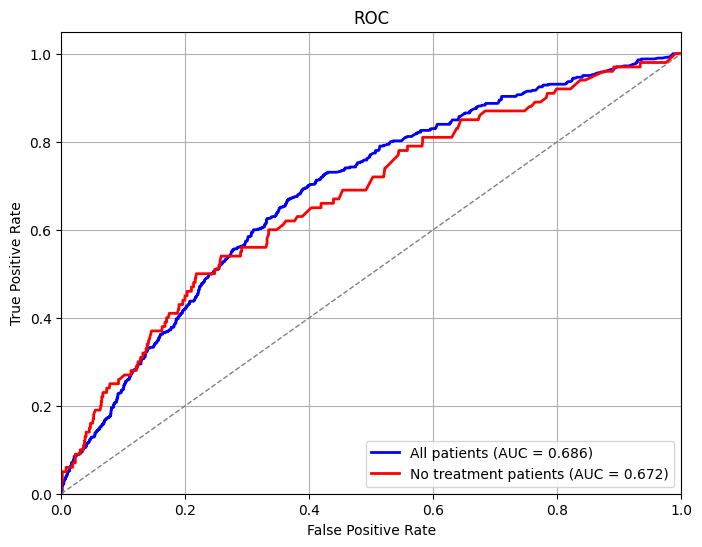

In [75]:
# ROC for all and for treatment patients
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
# All patients
fpr_all, tpr_all, _ = roc_curve(pred_df["y"], pred_df["pred"])
roc_auc_all = auc(fpr_all, tpr_all)
plt.plot(fpr_all, tpr_all, color='blue', lw=2, label='All patients (AUC = {:.3f})'.format(roc_auc_all))
# No treatment patients
fpr_notrt, tpr_notrt, _ = roc_curve(pred_dt_notrt["y"], pred_dt_notrt["pred"])
roc_auc_notrt = auc(fpr_notrt, tpr_notrt)
plt.plot(fpr_notrt, tpr_notrt, color='red', lw=2, label='No treatment patients (AUC = {:.3f})'.format(roc_auc_notrt))

plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()